In [36]:
#importing the necessary libraries
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [37]:
# load the data from CSV files
customers_df = pd.read_csv('/content/Customers.csv')
products_df = pd.read_csv('/content/Products.csv')
transactions_df = pd.read_csv('/content/Transactions.csv')

# merge the datasets based on common keys CustomerID and ProductID
merged_data = transactions_df.merge(customers_df, on='CustomerID').merge(products_df, on='ProductID')

customer_features = merged_data.groupby('CustomerID').agg(
    TotalTransactionValue=('TotalValue', 'sum'),
    TransactionCount=('TransactionID', 'count'),
).reset_index()

print(customer_features)

# create binary columns for each category the customer purchased
category_features = pd.get_dummies(merged_data[['CustomerID', 'Category']], columns=['Category'])

# one-hot encode customer regions for each region the customer belongs to
region_features = pd.get_dummies(customers_df[['CustomerID', 'Region']], columns=['Region'])

# combine all features into a single dataset
# merges aggregated transaction features, one-hot-encoded categories, and regions
final_features = (
    customer_features
    .merge(category_features.groupby('CustomerID').sum(), on='CustomerID')  # sum the category features per customer
    .merge(region_features, on='CustomerID')  # add region features
)

# normalizing the numeric features (mean = 0, standard deviation = 1)
scaler = StandardScaler()

normalized_features = pd.DataFrame(
    scaler.fit_transform(final_features.drop(columns=['CustomerID'])),  #except 'CustomerID'
    columns=final_features.columns[1:],  # keep column names except 'CustomerID'
    index=final_features['CustomerID']   # use 'CustomerID' as the index
)

    CustomerID  TotalTransactionValue  TransactionCount
0        C0001                3354.52                 5
1        C0002                1862.74                 4
2        C0003                2725.38                 4
3        C0004                5354.88                 8
4        C0005                2034.24                 3
..         ...                    ...               ...
194      C0196                4982.88                 4
195      C0197                1928.65                 3
196      C0198                 931.83                 2
197      C0199                1979.28                 4
198      C0200                4758.60                 5

[199 rows x 3 columns]


# KMeans Clustering

## Determining The Optimal Number Of Clusters


Let us use both elbow and silhouette methods to determine the optimal number of clusters.

### Elbow Method

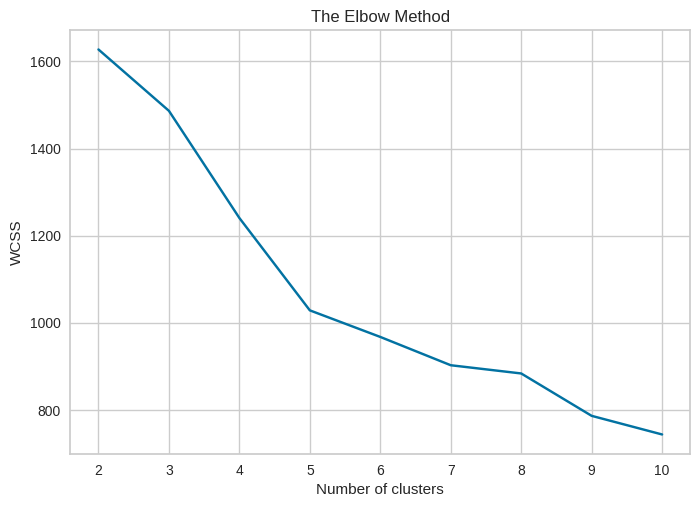

The optimal number of clusters according to the Elbow Method is: 10


In [38]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []  # within-cluster sum of square (WSS)

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(normalized_features)
    wcss.append(kmeans.inertia_)

#plotting the Elbow Method
plt.plot(range(2, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# finding the optimal number of clusters
optimal_clusters_elbow = range(2, 11)[wcss.index(min(wcss))]
print(f"The optimal number of clusters according to the Elbow Method is: {optimal_clusters_elbow}")

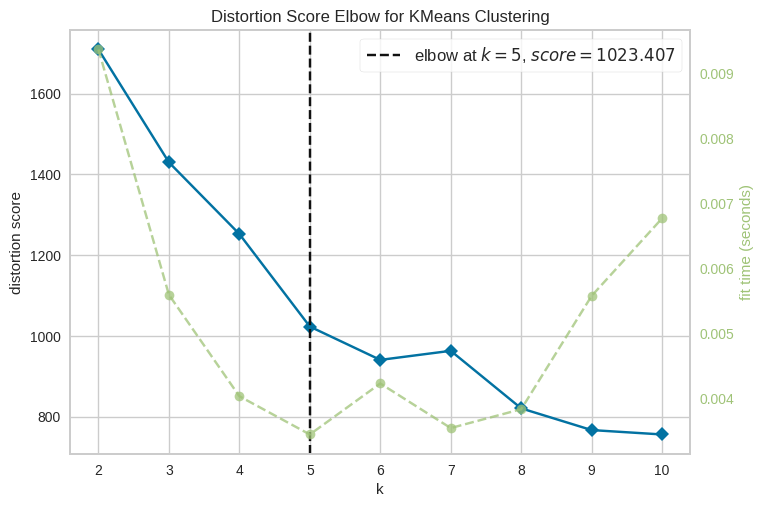

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(), k=(2,11), timings= True) # k is range of number of clusters.

visualizer.fit(normalized_features)        # fit data to visualizer
visualizer.show()

### Silhouette Score

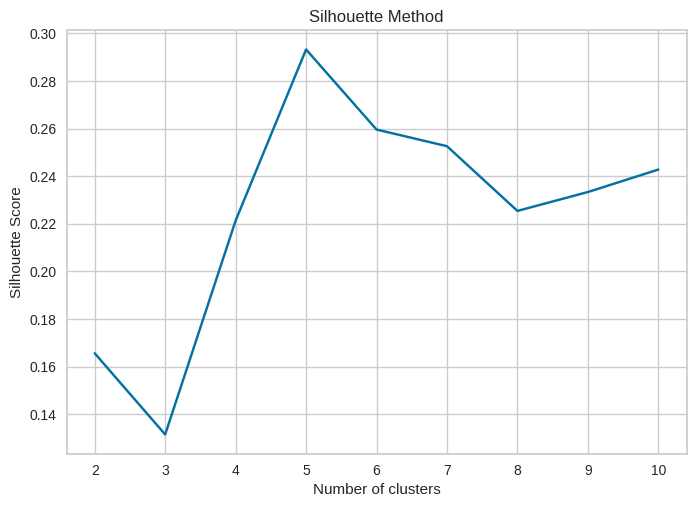

The optimal number of clusters is: 5


In [40]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ss = []
cluster_range = range(2, 11)  # number of clusters from 2 to 10

for i in cluster_range:
    km = KMeans(n_clusters=i, random_state=42)
    km.fit_predict(normalized_features)
    silhouette_avg = silhouette_score(normalized_features, km.labels_, metric='euclidean')  #calculate Silhouette Score
    ss.append(silhouette_avg)

# plotting the Silhouette Scores for different numbers of clusters
plt.plot(cluster_range, ss)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# finding the optimal number of clusters
optimal_clusters = cluster_range[ss.index(max(ss))]
print(f"The optimal number of clusters is: {optimal_clusters}")


## Davies-Bouldin Validation Metric

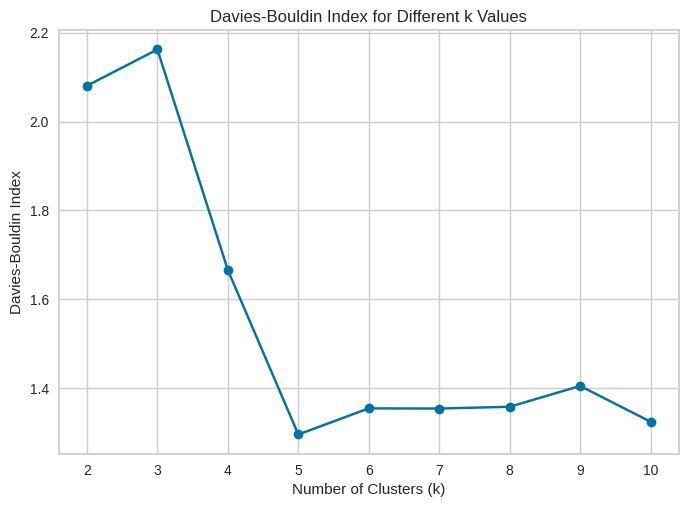

The optimal number of clusters according to the DB Method is: 5


In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# list to store DB Index values
db_index_values = []

#iterate through a range of cluster values (from 2 to 10)
for k in range(2, 11):  # number of clusters in the range of 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)

    # calculate Davies-Bouldin Index for the current k
    db_index = davies_bouldin_score(normalized_features, kmeans.labels_)
    db_index_values.append(db_index)

# plot DB Index to visualize the optimal 'k'
plt.plot(range(2, 11), db_index_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Different k Values')
plt.show()

# finding the optimal number of clusters (minimum DBI)
optimal_clusters_db = db_index_values.index(min(db_index_values)) + 2  # Add 2 because the range starts at 2
print(f"The optimal number of clusters according to the DB Method is: {optimal_clusters_db}")

**The above analysis clearly shows that the optimal number of clusters is 5.**

In [42]:
optimal_k = 5

In [48]:
# performing KMeans clustering with the optimal k
kmeans = KMeans(n_clusters = optimal_k, random_state=42)
kmeans.fit(normalized_features)

# add cluster labels to the dataframe
final_features['Cluster_KMeans'] = kmeans.labels_

In [49]:
final_features.head()

,CustomerID,TotalTransactionValue,TransactionCount,Category_Books,Category_Clothing,Category_Electronics,Category_Home Decor,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster,Cluster_Agglomerative,Cluster_DBSCAN,Cluster_KMeans
0,C0001,3354.52,5,1,0,3,1,False,False,False,True,1,2,-1,1
1,C0002,1862.74,4,0,2,0,2,True,False,False,False,3,1,-1,3
2,C0003,2725.38,4,0,1,1,2,False,False,False,True,1,2,-1,1
3,C0004,5354.88,8,3,0,2,3,False,False,False,True,1,6,-1,1
4,C0005,2034.24,3,0,0,2,1,True,False,False,False,3,1,-1,3


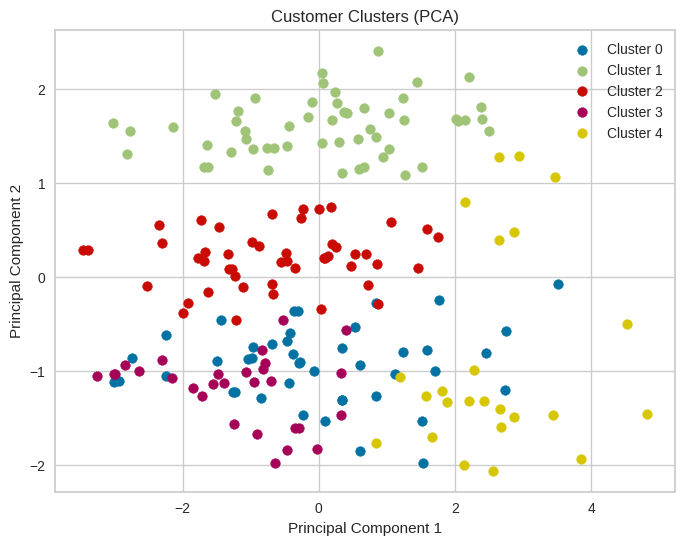

In [45]:
#to visualize the clusters, let us use PCA with 2 principal components.

pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_features)
plt.figure(figsize=(8, 6))

for cluster_label in range(optimal_k):
    cluster_data = principal_components[final_features['Cluster'] == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Clusters (PCA)')
plt.legend()
plt.show()

## Agglomerative Clustering

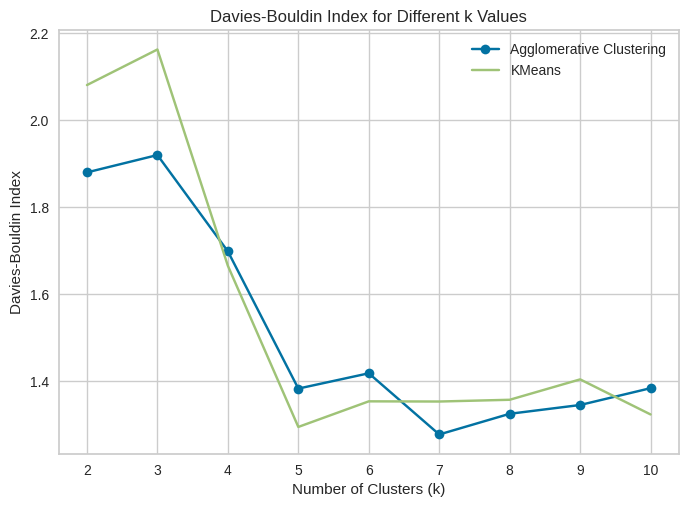

Optimal k for Agglomerative Clustering: 7
Davies-Bouldin Index for Agglomerative Clustering: 1.2777643049525607


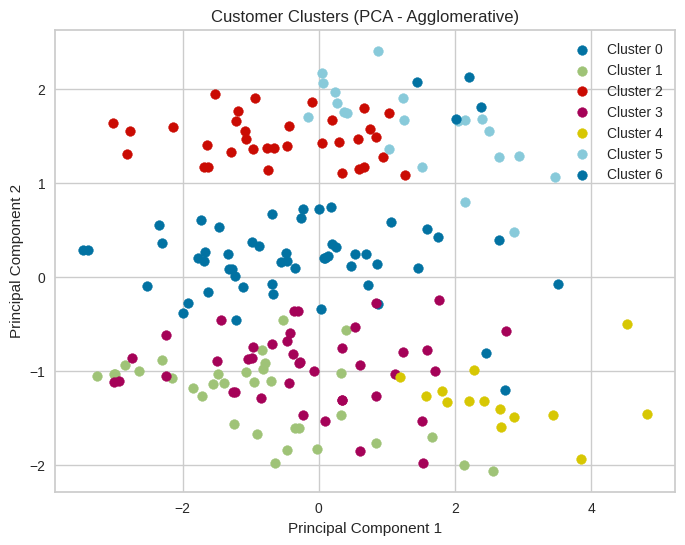

In [46]:
from sklearn.cluster import AgglomerativeClustering

# Find optimal number of clusters using Davies-Bouldin Index for Agglomerative Clustering
db_index_values_agglomerative = []
for k in range(2, 11):
    agglomerative = AgglomerativeClustering(n_clusters=k)
    agglomerative.fit(normalized_features)
    db_index = davies_bouldin_score(normalized_features, agglomerative.labels_)
    db_index_values_agglomerative.append(db_index)

# Plot DB Index for Agglomerative Clustering
plt.plot(range(2, 11), db_index_values_agglomerative, marker='o', label='Agglomerative Clustering')
plt.plot(range(2, 11), db_index_values, marker='x', label='KMeans') #Plot KMeans for comparison
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Different k Values')
plt.legend()
plt.show()

# Find the optimal k for Agglomerative Clustering based on the plot (lowest DB Index)
optimal_k_agglomerative =  db_index_values_agglomerative.index(min(db_index_values_agglomerative)) + 2 #Adjust for the 2-10 range used

# Perform Agglomerative Clustering with the optimal k
agglomerative = AgglomerativeClustering(n_clusters=optimal_k_agglomerative)
agglomerative.fit(normalized_features)

# Calculate the DB Index for Agglomerative Clustering
db_index_agglomerative = davies_bouldin_score(normalized_features, agglomerative.labels_)

# Add cluster labels to the dataframe
final_features['Cluster_Agglomerative'] = agglomerative.labels_

print(f"Optimal k for Agglomerative Clustering: {optimal_k_agglomerative}")
print(f"Davies-Bouldin Index for Agglomerative Clustering: {db_index_agglomerative}")

# Visualize with PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_features)
plt.figure(figsize=(8, 6))

for cluster_label in range(optimal_k_agglomerative):
    cluster_data = principal_components[final_features['Cluster_Agglomerative'] == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Clusters (PCA - Agglomerative)')
plt.legend()
plt.show()

## DBScan Clustering Algorithm

Let us now try DBScan algorithm and check.

Best eps: 0.5
Best min_samples: 3
Best Davies-Bouldin Index for DBSCAN: 0.8581085325201828


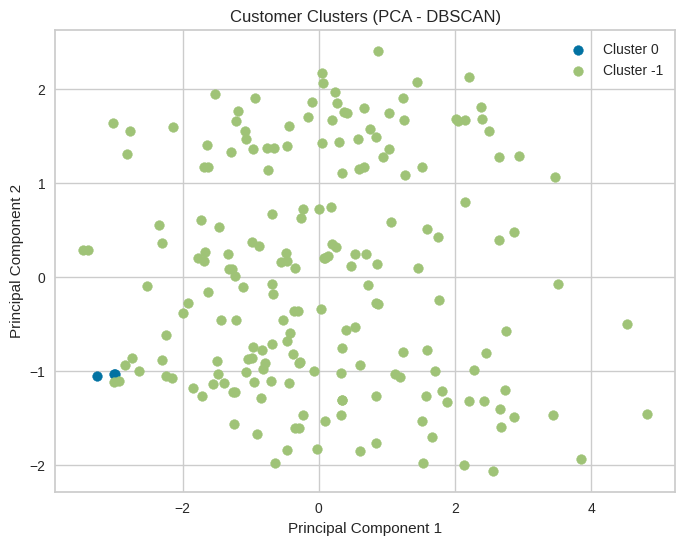

In [47]:
from sklearn.cluster import DBSCAN

# Find optimal parameters for DBSCAN using Davies-Bouldin Index
best_db_index = float('inf')
best_eps = 0
best_min_samples = 0

for eps in [0.5, 1, 1.5, 2, 2.5]:
    for min_samples in range(2, 11):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(normalized_features)

        # Check for a single cluster
        if len(set(dbscan.labels_)) <=1 :
          continue

        db_index = davies_bouldin_score(normalized_features, dbscan.labels_)
        if db_index < best_db_index:
            best_db_index = db_index
            best_eps = eps
            best_min_samples = min_samples

print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Davies-Bouldin Index for DBSCAN: {best_db_index}")

# Perform DBSCAN with the best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(normalized_features)

# Add cluster labels to the dataframe
final_features['Cluster_DBSCAN'] = dbscan.labels_

# Visualize with PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_features)
plt.figure(figsize=(8, 6))

for cluster_label in set(dbscan.labels_):
    cluster_data = principal_components[final_features['Cluster_DBSCAN'] == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Clusters (PCA - DBSCAN)')
plt.legend()
plt.show()